In [1]:
import torch
import numpy as np
import matplotlib.pylab as plt

In [2]:
import sys
sys.path.insert(0,'vp_class/')

**Import class**

In [3]:
from class_vp_ou import OU, OU_Score
from class_vp_tou import tOU, tOU_Score

**Finding MLE estimator for time-homogeneous Ornstein-Uhlenbeck process**

1. Simulate two sample path from OU process

In [4]:
D = 2
alpha = torch.tensor(10.).repeat(D, 1)
beta = torch.tensor([1.,2.]).reshape(-1,1)
z0 = torch.randn((D, 1))
sigma = torch.tensor(1.).repeat(D,1)

**Note that the diffusion simulation based on Euler-Maruyama results in very smooth plot once dt > 2.**

In [6]:
true_ou = OU(t0 = 3., t1 = 4., z0 = z0, alpha = alpha, beta = beta, sigma = sigma, dN=300, D = D, timegrid='True')

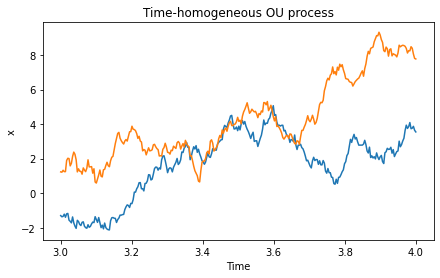

In [10]:
plt.figure(figsize=(7, 4))
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Time-homogeneous OU process")
plt.plot(true_ou.pts.T, true_ou.trj.T)
plt.show()

2. Implement gradient descent algorithm to find the MLE

In [11]:
alpha_ = torch.randn((2, 1))
beta_ = torch.tensor([5., 5.]).reshape(-1,1)

learning_rate = 0.05

for i in range(10000):
    lr = 0.1
    mle = OU_Score(true_ou)
    update = mle.compute_score(alpha = alpha_, beta=beta_)
    
    alpha_ += learning_rate * update['alpha']
    beta__ =  beta_ + learning_rate * update['beta']
    
    
    while any(beta__ < 0):
        for d in range(beta_.shape[0]):
            if beta__[d] < 0:
                while beta__[d] < 0:
                    beta__[d] = beta_[d] + lr * update['beta'][d]
                    lr *= 0.5
    beta_ = beta__
    if i % 1000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'LL = ', update['LL'])

beta =  [[3.35740526]
 [1.95396618]] alpha =  [[3.2566036 ]
 [6.76654042]] LL =  [-1808.60174695 -2298.24369017]
beta =  [[0.88429744]
 [0.85710756]] alpha =  [[ 7.15420991]
 [10.14158496]] LL =  [-1703.38556505 -1912.17753733]
beta =  [[0.88173292]
 [0.83982574]] alpha =  [[ 7.1720091 ]
 [10.26358169]] LL =  [-1703.3855513  -1912.05618906]
beta =  [[0.88168924]
 [0.83181034]] alpha =  [[ 7.17231304]
 [10.31071639]] LL =  [-1703.38555129 -1912.0138717 ]
beta =  [[0.88168849]
 [0.11630313]] alpha =  [[ 7.17231827]
 [10.27749204]] LL =  [-1703.38555129 -1920.19833914]
beta =  [[0.88168848]
 [0.62908124]] alpha =  [[ 7.17231836]
 [10.40226931]] LL =  [-1703.38555129 -1912.82593025]
beta =  [[0.88168848]
 [0.21490069]] alpha =  [[ 7.17231837]
 [10.23761366]] LL =  [-1703.38555129 -1918.74341853]
beta =  [[0.88168848]
 [0.6023509 ]] alpha =  [[ 7.17231837]
 [10.53161024]] LL =  [-1703.38555129 -1912.71597525]
beta =  [[0.88168848]
 [0.12455363]] alpha =  [[ 7.17231837]
 [10.50235643]] LL = 

**Comparision: observations vs sample (from OU with MLE)**

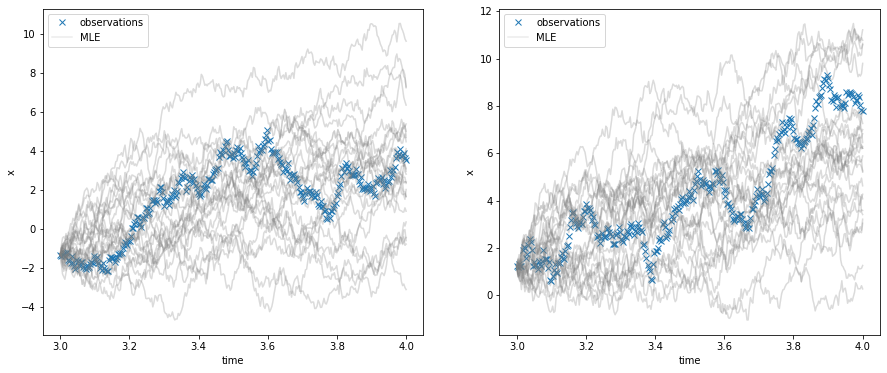

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
# plt.title("Fitted Process: MLE")
for j, ax in enumerate(ax.ravel()):
    ax.plot(true_ou.pts[j], true_ou.trj[j], 'x', label='observations')
    for i in range(25):
        vi = OU(t0 = 3., t1 = 4., z0 = z0, alpha = alpha_, beta = beta_, sigma = sigma, dN=300, D = D, timegrid='True')    
        ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey')
        ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey')
        if i == 24:
            ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey', label='MLE')
    ax.set_xlabel("time")
    ax.set_ylabel("x")
    ax.legend()
plt.show()

In [13]:
print("True alpha = \n", alpha.data.numpy(), "\nAlpha_MLE = \n", alpha_.data.numpy(), "\nTrue Beta = \n", beta.data.numpy(), "\nBeta_MLE = \n", beta_.data.numpy())

True alpha = 
 [[10.]
 [10.]] 
Alpha_MLE = 
 [[7.17231837]
 [9.94526202]] 
True Beta = 
 [[1.]
 [2.]] 
Beta_MLE = 
 [[0.88168848]
 [1.0010737 ]]


**Finding MLE estimator for time-inhomogeneous Ornstein-Uhlenbeck process**

1. Simulate 2 sample paths from time-inhomogeneous OU processes

In [14]:
alpha = torch.tensor([0.633, -0.633]).reshape(2, -1)
beta = torch.tensor([3.59, 3.59]).reshape(2, -1)
r = torch.tensor([1.124, 1.124]).reshape(2, -1)
m0 = torch.tensor([1.79, 1.79]).reshape(2, -1)

In [15]:
true_sde = tOU(t0=0, t1=2, z0=m0, m0=m0, alpha=alpha, beta=beta, sigma=1, r=r, dN=40, D=2, timegrid = 'False')

Show simulated trajectories along with their (theoretical) mean

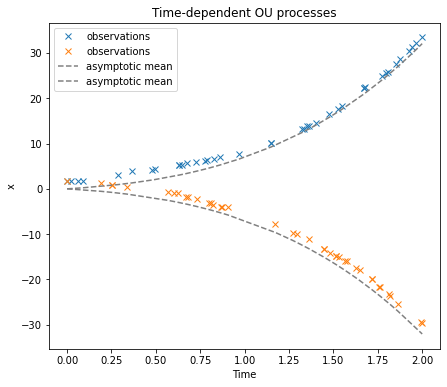

In [16]:
post_mean = lambda x: alpha * (((x + 1) ** beta) - 1) + 0
plt.figure(figsize=(7, 6))
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')
plt.plot(true_sde.pts.T, post_mean(true_sde.pts).T, color='grey', linestyle='dashed', label='asymptotic mean')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Time-dependent OU processes")
plt.show()

2. Apply gradient descent algorithm to find the MLE

We make inferences for the parameters of the above sample paths based on gradient descent algorithm. The algorithm is vectorized. 

Note: Gradient descent algorithm is sensitive to initaliziation, in partciular, the sign of $\alpha$. Hence, it is better to initialize $\alpha$ around 0 so that the algorithm finds the right "direction"*

In [17]:
beta_ = torch.tensor([0.5, 0.5], dtype=torch.float64).reshape(2,-1)
alpha_ = torch.tensor([0., 0.], dtype=torch.float64).reshape(2,-1)
r_ = torch.tensor([1., 1.], dtype=torch.float64).reshape(2,-1)

learning_rate = 0.000005
lr = learning_rate
for i in range(50000):
    mle = tOU_Score(true_sde)
    update = mle.compute_score(beta = beta_, alpha=alpha_, m0=m0, r=r_)
    beta_ +=  learning_rate * update['beta']
    alpha_ += learning_rate * update['alpha']
    r__ = r_ + learning_rate * update['r']
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while any(r__ < 0):
        for d in range(r__.shape[0]):
            if r__[d] < 0:
                while r__[d] < 0:
                    r__[d] = r_[d] + lr * update['r'][d]
                    lr *= 0.5
    r_ = r__
        
    if i % 10000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'r = ', r_.data.numpy())
        print("MLE = ", update['LNN'])

beta =  [[0.5]
 [0.5]] alpha =  [[ 0.00022328]
 [-0.00022378]] r =  [[0.99580595]
 [0.99575502]]
MLE =  [-1008.78441623  -982.84337615]
beta =  [[1.40583791]
 [1.36997126]] alpha =  [[ 0.96567604]
 [-0.94498571]] r =  [[0.00014039]
 [0.00069405]]
MLE =  [-282.30940637 -261.11943325]
beta =  [[3.0124905 ]
 [2.90398364]] alpha =  [[ 1.29716594]
 [-1.4300136 ]] r =  [[3.72795703e-08]
 [2.19092292e-08]]
MLE =  [26.78589597 29.14908825]
beta =  [[3.27971474]
 [3.05659546]] alpha =  [[ 0.93177359]
 [-1.181515  ]] r =  [[3.72795703e-08]
 [2.19092292e-08]]
MLE =  [30.91492448 30.85976082]
beta =  [[3.50964703]
 [3.18562158]] alpha =  [[ 0.70256154]
 [-1.00623927]] r =  [[3.72795703e-08]
 [2.19092292e-08]]
MLE =  [33.05710084 31.81673139]


Compare simulated path vs path from MLE

Based on MLE estimator, we sample 50 different sample paths from the time-dependent OU. It is clear that these paths encaptulates our observations.

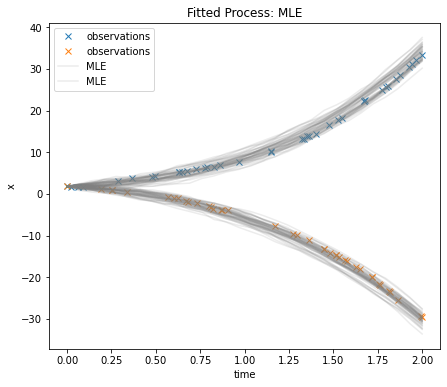

In [18]:
plt.figure(figsize=(7,6))
plt.title("Fitted Process: MLE")
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')
for i in range(50):
    vi = tOU(0, 2, m0, m0, alpha_, beta_, 1., r_, D=2, dN = 30)
    plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey')
    if i == 49:
        plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey', label='MLE')
plt.xlabel("time")
plt.ylabel("x")
plt.legend()
plt.show()

In [19]:
print("True alpha =", alpha, "\nMLE alpha = ", alpha_[:])
print("True beta = ", beta[:], "\nMLE beta = ", beta_[:])
print("Ture r = ", r[:], "\nMLE r = ", r_[:])

True alpha = tensor([[ 0.6330],
        [-0.6330]]) 
MLE alpha =  tensor([[ 0.5778],
        [-0.8924]])
True beta =  tensor([[3.5900],
        [3.5900]]) 
MLE beta =  tensor([[3.6698],
        [3.2825]])
Ture r =  tensor([[1.1240],
        [1.1240]]) 
MLE r =  tensor([[3.7280e-08],
        [2.1909e-08]])
